In [1]:
#this notebook reads the experimental and simulation data from a defined directory
#then a fitting on all data is performed using the best regularization type and strength
#corrections can be customized in order to investigate the impact of single corrections in gHBfix_opt
#results published in this study can be obtained ...
# ... by following the instruction for uncommenting or activating the adequate lines of code ...
# ... relevant for settings of the optimization and saving and loading files

In [2]:
import bussilab
import scipy
from scipy.optimize import minimize
import cudamat as cm
import concurrent.futures
import numpy as np
import matplotlib.pyplot as plt
import re
kBT=0.6 #kBT in kcal/mol
np.random.seed(1995)
import os

In [3]:
def concatenate_simulation_data(files):
    result=None
    for t in files:
        if result is None:
            result=np.load(t)
            output=+result
        else:
            result=np.load(t)
            output=np.concatenate((output,result))

    return output

def read_TLs(files):
    corr=[]
    for file in files:
        with open(file, "r") as f:
            for line in f:
                nums=line.split()
                if nums:
                    corr.append(np.array([float(i) for i in nums]))
    return np.array(corr)

In [4]:
def calculate_TL_bias(Sequence,key,prune,skip,trajGAGA,FFprefactorsGAGA,trajUUCG,FFprefactorsUUCG):
    
    directories=["nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping", 
                 "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping_bias-from-half-half",
                 "nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping_bias-from-one-zero",
                 "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping"
                 ]

    collection_weights=[]
    for index,d in enumerate(directories):
        Metadweight=[]
        with open("./data_loaded/%s/%s/weights.rep0" %(Sequence,d) ,"r") as fp:
            for line in fp:
                Metadweight.append(float(line))
        collection_weights.append(np.array(Metadweight))

    MetadPot1=np.concatenate((collection_weights[0],collection_weights[1]))
    MetadPot2=np.concatenate((collection_weights[2],collection_weights[3]))

    MetadPot=np.c_[ MetadPot1,MetadPot2 ] 
    MetadPot=kBT*np.log(MetadPot)
    
    if prune==True:
        MetadPot=MetadPot[::skip,:]
    
    if Sequence=='GAGA':
        if key == 'reference':
            bias=np.matmul(trajGAGA,np.array(FFprefactorsGAGA).T)+MetadPot
        if key == 'proposed':
            bias=np.matmul(trajGAGA,(FFprefactorsGAGA-FFprefactorsGAGA[1]).T)+MetadPot
        
    if Sequence=='UUCG':
        if key == 'reference':
            bias=np.matmul(trajUUCG,np.array(FFprefactorsUUCG).T)+MetadPot
        if key == 'proposed':
            bias=np.matmul(trajUUCG,(FFprefactorsUUCG-FFprefactorsUUCG[1]).T)+MetadPot
        

    del MetadPot1
    del MetadPot2
    del MetadPot
        
    return bias   

In [5]:
def activate_cuda(traj,weights, USE_CUDA):

    if USE_CUDA:
        cm.init(max_ones=traj.shape[0])
        cm_traj=cm.CUDAMatrix(traj.T)
        cm_weights=cm.CUDAMatrix(np.reshape(weights,(1,-1)))
        return cm_traj, cm_weights
    else:
        return traj,weights

def compute_newweights(par,cm_traj,cm_weights,USE_CUDA):
    if USE_CUDA:
        cm_par=cm.CUDAMatrix(np.reshape(par,(1,-1)))
        cm_correction=cm.dot(cm_par,cm_traj)
        
        m=float(cm_correction.min(axis=1).asarray()[0,0])
        cm_correction.subtract(m)
        cm_correction.mult(-1.0)
        newweights=cm.exp(cm_correction)
        newweights.mult_by_row(cm_weights)
        newweights.mult(1.0/(cm.sum(newweights,axis=1).asarray()[0,0]))
        return newweights 
    else:
        correction=np.matmul(cm_traj,par)
        correction-=np.min(correction)
        newweights=np.exp(-correction)*cm_weights
        return newweights/np.sum(newweights)
    
def function(par,obs,newweights,traj,cm_traj,USE_CUDA):
    gradient=True
    if USE_CUDA:
        if(isinstance(obs,cm.CUDAMatrix)):
            cm_obs=obs
        else:
            cm_obs=cm.CUDAMatrix(obs)
        if(isinstance(newweights,cm.CUDAMatrix)):
            cm_newweights=newweights
        else:
            cm_newweights=cm.CUDAMatrix(np.reshape(newweights,(1,-1)))
        av_obs=np.reshape(np.array(cm.dot(cm_newweights,cm_obs).asarray()),(-1))
    else:
        av_obs=np.reshape(np.array(np.matmul(newweights,obs)),(-1))
    
    if not gradient:
        return av_obs
    
    dav=np.zeros((len(par),obs.shape[1]))
    
    if USE_CUDA:
        cm_traj_weighted=cm.empty((traj.shape[1],traj.shape[0]))
        cm_traj_weighted.assign(cm_traj)
        cm_traj_weighted.mult_by_row(cm_newweights)
        av_traj=np.reshape(cm_traj_weighted.sum(axis=1).asarray(),(-1))
        dav=-cm.dot(cm_traj_weighted,cm_obs).asarray()
    else:
        weighted_traj=np.copy(traj)
        for ipar in range(len(par)):
            weighted_traj[:,ipar]=newweights*traj[:,ipar]
        av_traj=np.matmul(newweights,traj)
        for ipar in range(len(par)):
            for iobs in range(obs.shape[1]):
                dav[ipar,iobs]=-np.sum(weighted_traj[:,ipar]*obs.T[iobs,:])

    for ipar in range(len(par)):
        for iobs in range(obs.shape[1]):
            dav[ipar,iobs]+=av_obs[iobs]*av_traj[ipar]
            
    return av_obs,dav

In [6]:
def _logsum(ns):
    max = np.max(ns)
    ds = ns - max
    sumOfExp = np.exp(ds).sum()
    return max + np.log(sumOfExp)

In [7]:
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [8]:
def func_and_grad(par,noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,regularization,alpha,gradient=True,regularize=True,components=False):
    func=0.0
    chi2_native_GAGA=0.0
    chi2_native_UUCG=0.0
    chi2_noe=0.0
    chi2_unoe=0.0
    chi2_backbone1=0.0
    chi2_backbone2=0.0
    chi2_sugar=0.0
    
    if gradient:
        grad=np.zeros(len(par))
        grad_backbone1=np.zeros(len(par))
        grad_backbone2=np.zeros(len(par))
        grad_sugar=np.zeros(len(par))
        grad_noe=np.zeros(len(par))
        grad_unoe=np.zeros(len(par))
        grad_native_GAGA=np.zeros(len(par))
        grad_native_UUCG=np.zeros(len(par))
    
    
    
    USE_CUDA=True
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])
    
    funcGAGA=0.0
    gradGAGA=np.zeros(len(par))
    if obs_weight[0] != 0:
        chi2_native_GAGA=0.0
        cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        f=function(par,populationGAGA,w, trajGAGA,cm_traj, USE_CUDA)
        target_population=0.5
        diff=np.log(f[0]+eps)-np.log(target_population)
        if(diff<.0):
                chi2_native_GAGA+=diff**2
                if gradient:
                    grad_native_GAGA+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
        funcGAGA=obs_weight[0]*TLweight*chi2_native_GAGA
        if gradient:
            gradGAGA=obs_weight[0]*TLweight*grad_native_GAGA
        
    
    funcUUCG=0.0
    gradUUCG=np.zeros(len(par))
    if obs_weight[1] != 0:
        chi2_native_UUCG=0.0
        cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        f=function(par,populationUUCG,w, trajUUCG,cm_traj, USE_CUDA)
        target_population=0.5
        diff=np.log(f[0]+eps)-np.log(target_population)
        if(diff<.0):
                chi2_native_UUCG+=diff**2
                if gradient:
                    grad_native_UUCG+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
        funcUUCG=obs_weight[1]*TLweight*chi2_native_UUCG
        if gradient:
            gradUUCG=obs_weight[1]*TLweight*grad_native_UUCG
    
    func+=prefactor*(funcGAGA+funcUUCG)
    if gradient:
        grad+=prefactor*(gradGAGA+gradUUCG)
    
    USE_CUDA=True
    cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
    w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)
    
    if obs_weight[2] != 0:
        f=function(par,noe,w, trajGACC,cm_traj, USE_CUDA)
        chi2_noe=np.sum(((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1])**2)/noe_exp.shape[0]
        func+=obs_weight[2]*noe_exp.shape[0]*chi2_noe
        if gradient:
            grad_noe+=np.matmul(f[1],(2/noe_exp.shape[0] * ((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1]) * (-1/6) * f[0]**(-7/6))/noe_exp[:,1])
            grad+=obs_weight[2]*noe_exp.shape[0]*grad_noe
    
    if obs_weight[3] != 0:
        f=function(par,unoe,w, trajGACC,cm_traj, USE_CUDA)
        chi2_unoe=0.0
        for i in range(len(f[0])):
            diff=f[0][i]**(-1/6)-unoe_exp[i,0]
            if(diff<.0):
                chi2_unoe+=(diff/unoe_exp[i,1])**2/unoe_exp.shape[0]
                if gradient:
                    grad_unoe+=f[1][:,i]*2/unoe_exp.shape[0]* diff/unoe_exp[i,1]* (-1/6) * f[0][i]**(-7/6) /unoe_exp[i,1]
        func+=obs_weight[3]*unoe_exp.shape[0]*chi2_unoe
        if gradient:
            grad+=obs_weight[3]*unoe_exp.shape[0]*grad_unoe
    
    if obs_weight[4] != 0:
        f=function(par,backbone1,w, trajGACC,cm_traj, USE_CUDA)
        chi2_backbone1=np.sum(((f[0]-backbone1_exp[:,0])/backbone1_exp[:,1])**2)/backbone1_exp.shape[0]
        func+=obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1
        if gradient:
            grad_backbone1+=np.matmul(f[1],2/backbone1_exp.shape[0] * (f[0]-backbone1_exp[:,0])/backbone1_exp[:,1]/backbone1_exp[:,1])
            grad+=obs_weight[4]*backbone1_exp.shape[0]*grad_backbone1
    
    if obs_weight[5] != 0:
        f=function(par,backbone2,w, trajGACC,cm_traj, USE_CUDA)
        chi2_backbone2=np.sum(((f[0]-backbone2_exp[:,0])/backbone2_exp[:,1])**2)/backbone2_exp.shape[0]
        func+=obs_weight[5]*backbone2_exp.shape[0]*chi2_backbone2
        if gradient:
            grad_backbone2+=np.matmul(f[1],2/backbone2_exp.shape[0] * (f[0]-backbone2_exp[:,0])/backbone2_exp[:,1]/backbone2_exp[:,1])
            grad+=obs_weight[5]*backbone2_exp.shape[0]*grad_backbone2
    
    if obs_weight[6] != 0:
        f=function(par,sugar,w, trajGACC,cm_traj, USE_CUDA)
        chi2_sugar=np.sum(((f[0]-sugar_exp[:,0])/sugar_exp[:,1])**2)/sugar_exp.shape[0]
        func+=obs_weight[6]*sugar_exp.shape[0]*chi2_sugar
        if gradient:
            grad_sugar+=np.matmul(f[1],2/sugar_exp.shape[0] * (f[0]-sugar_exp[:,0])/sugar_exp[:,1]/sugar_exp[:,1])
            grad+=obs_weight[6]*sugar_exp.shape[0]*grad_sugar
    
    denominator=(obs_weight[0]*TLweight+obs_weight[1]*TLweight+obs_weight[2]*noe_exp.shape[0]+obs_weight[3]*unoe_exp.shape[0] + obs_weight[4]*backbone1_exp.shape[0]+ obs_weight[5]*backbone2_exp.shape[0]+obs_weight[6]*sugar_exp.shape[0])
    func/=denominator
    
    
    if gradient:
        grad/=denominator
    
    if regularize:
        if regularization == 'L1':
            regL1=alpha * np.sum(np.sqrt(eps+par**2))
            func+=regL1
            if gradient:
                grad_regL1=(alpha*par)/(np.sqrt(eps+par**2))
                grad+=grad_regL1


        if regularization == 'L2':
            regL2=alpha * np.sum(par**2)
            func+=regL2
            if gradient:
                grad_regL2=2*alpha*par
                grad+=grad_regL2

        if regularization == 'KishSize':
            USE_CUDA=True
            cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
            wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            t=[trajGACC, trajGAGA, trajUUCG] 
            w_list=[weightsGACC, weightsGAGA, weightsUUCG]
            new_weights=[wGACC,wGAGA,wUUCG]
            
            
            kish=np.sum((new_weights[0]**2))
            kish_GAGA=np.sum((new_weights[1]**2))
            kish_UUCG=np.sum((new_weights[2]**2))
            
            kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))
            chi2_kish=alpha*kish_size
            func+=chi2_kish

            if gradient:
                grad_array=[0.0,0.0,0.0]

                for index,elem in enumerate(new_weights):
                    w_i=(elem**2)
                    c_a_i=t[index]
                    c_ave=np.matmul(new_weights[index],c_a_i)
                    grad_array[index]=-2*alpha*np.matmul(w_i,(c_a_i - c_ave)) 
                    grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]
                    
                grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)
                
        if regularization == 'RelativeKishSize':
            USE_CUDA=True
            cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
            wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            t=[trajGACC, trajGAGA, trajUUCG] 
            w_list=[weightsGACC, weightsGAGA, weightsUUCG]
            new_weights=[wGACC,wGAGA,wUUCG]

            Nf_list=[len(trajGACC),len(trajGAGA),len(trajUUCG)]
            kish=np.sum((eps+(new_weights[0]**2))/(eps+w_list[0]))/Nf_list[0]
            kish_GAGA=np.sum((eps+(new_weights[1]**2))/(eps+w_list[1]))/Nf_list[1]
            kish_UUCG=np.sum((eps+(new_weights[2]**2))/(eps+w_list[2]))/Nf_list[2]

            kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))

            chi2_kish=alpha*kish_size
            func+=chi2_kish

            if gradient:
                grad_array=[0.0,0.0,0.0]

                for index,elem in enumerate(new_weights):
                    w_i=eps+(elem**2)
                    w_i/=(eps+w_list[index])
                    c_a_i=t[index]

                    c_ave=np.matmul(new_weights[index],c_a_i)
                    grad_array[index]=np.matmul(w_i,(c_a_i - c_ave))
                    grad_array[index]*=-(2*alpha)
                    grad_array[index]/=Nf_list[index]

                    grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

        if regularization == 'RelativeEntropy':
            USE_CUDA=True
            cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
            wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            t=[trajGACC, trajGAGA, trajUUCG] 
            w_list=[weightsGACC, weightsGAGA, weightsUUCG]
            new_weights=[wGACC,wGAGA,wUUCG]

            entropy=np.exp(np.sum(new_weights[0]*np.log((new_weights[0])/(w_list[0])+eps)))
            entropy_GAGA=np.exp(np.sum(new_weights[1]*np.log((new_weights[1])/(w_list[1])+eps)))
            entropy_UUCG=np.exp(np.sum(new_weights[2]*np.log((new_weights[2])/(w_list[2])+eps)))

            relative_entropy=_logsum(np.array([entropy,entropy_GAGA,entropy_UUCG]))

            chi2_entropy=alpha*relative_entropy
            func+=chi2_entropy

            if gradient:
                grad_array=[0.0,0.0,0.0]

                for index,elem in enumerate(new_weights):
                    w_i=(elem) 
                    w_i_0=w_list[index]
                    c_a_i=t[index]
                    c_ave=np.matmul(eps+new_weights[index],c_a_i)
                    grad_array[index]=np.array([entropy,entropy_GAGA,entropy_UUCG])[index]

                    part1=-np.matmul(w_i*np.log((w_i/w_i_0)+eps),(c_a_i - c_ave))
                    part2=alpha*part1-alpha*np.matmul(w_i,(c_a_i - c_ave))
                    grad_array[index]*=part2

                    grad_array[index]*=_softmax(np.array([entropy,entropy_GAGA,entropy_UUCG]))[index]

                grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)
    
    
    if gradient:
        return float(func), np.array(grad)        
    
    if components:
        chi2_native_GAGA=float(obs_weight[0]*TLweight*chi2_native_GAGA)
        chi2_native_UUCG=float(obs_weight[1]*TLweight*chi2_native_UUCG)
        chi2_noe=float(obs_weight[2]*noe_exp.shape[0]*chi2_noe)
        chi2_unoe=float(obs_weight[3]*unoe_exp.shape[0]*chi2_unoe)
        chi2_backbone1=float(obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1)
        chi2_backbone2=float(obs_weight[4]*backbone2_exp.shape[0]*chi2_backbone2)
        chi2_sugar=float(obs_weight[5]*sugar_exp.shape[0]*chi2_sugar)
        
        return float(func), chi2_backbone1/denominator,chi2_backbone2/denominator,chi2_sugar/denominator,chi2_noe/denominator,chi2_unoe/denominator, chi2_native_GAGA/denominator,chi2_native_UUCG/denominator  
    
    return float(func)

In [9]:
def func_and_grad_less(par,priority_lambdas,noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,regularization,alpha,gr=True,regz=True,comp=False):
    allpar=np.zeros(12)  
    
    mappa= priority_lambdas
    k=0
    for i in mappa: 
        allpar[i]=par[k]
        k+=1
        
    if allpar[1]==0:
        allpar[1]-=1.666666666666666/1
    if allpar[6]==0:
        allpar[6]+=1.666666666666666/0.5
    if allpar[8]==0:
        allpar[8]+=1.666666666666666/0.5
        
    f,grad=func_and_grad(allpar,noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,regularization,alpha,gradient=gr,regularize=regz,components=comp)
    k=0
    fewgrad=np.zeros(len(mappa))
    for i in range(len(grad)):
        if i in priority_lambdas:
            fewgrad[k]=grad[i]
            k+=1
    return f,fewgrad

In [10]:
def save_single_min(data,which_interaction_index_to_exclude):
    
    chi2_col=data[1]
    chi2_ref_col=data[2]
    chi2_native_GAGA_col=data[3]
    chi2_native_UUCG_col=data[4]
    chi2_noes_col=data[5]
    chi2_unoes_col=data[6]
    chi2_sugar_col=data[7]
    chi2_backbone1_col=data[8]
    chi2_backbone2_col=data[9]
    populationGAGA_col=data[10]
    populationUUCG_col=data[11]
    
    temp=np.array([chi2_col,
chi2_ref_col,
chi2_native_GAGA_col,
chi2_native_UUCG_col,
chi2_noes_col,
chi2_unoes_col,
chi2_sugar_col,
chi2_backbone1_col,
chi2_backbone2_col,
populationGAGA_col,
populationUUCG_col],dtype='object')
    
    #...activate/uncomment the lines of interest
    
    #np.save("./data_produced/FitYourself_errors.npy",temp)
    #np.save("./data_produced/FitYourself_errors_2OH2OH.npy",temp)
    #np.save("./data_produced/FitYourself_errors_NH2OH.npy",temp)
    #np.save("./data_produced/FitYourself_errors_NHO_05.npy",temp)
    np.save("./data_produced/FitYourself_errors_*2OH.npy",temp)
    lambdas = np.asarray(data[0])
    #np.save("./data_produced/FitYourself_Lambdas.npy", lambdas)
    #np.save("./data_produced/FitYourself_Lambdas_2OH2OH.npy",lambdas)
    #np.save("./data_produced/FitYourself_Lambdas_NH2OH.npy",lambdas)
    #np.save("./data_produced/FitYourself_Lambdas_NHO_05.npy",lambdas)
    np.save("./data_produced/FitYourself_Lambdas_*2OH.npy",lambdas)

In [11]:
def reorder(input_array):
    
    temp=input_array
    
    input_array=np.array([temp[1],temp[4],temp[3],temp[5],temp[0],temp[2],temp[7],temp[10],temp[9],temp[11],temp[6],temp[8]])
    
    return input_array

In [12]:
def main():
    
    print("Load experimental data")
    noe_exp=np.loadtxt("./data_loaded/GACC/exp_noes",usecols=(2,3))
    unoe_exp=np.loadtxt("./data_loaded/GACC/exp_unobs-noes",usecols=(2,3))
    sugar_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-sugar",usecols=(1,2))
    backbone1_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-1",usecols=(1,2))
    backbone2_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-2",usecols=(1,2))
    print(noe_exp.shape)
    print(unoe_exp.shape)
    print(sugar_exp.shape)
    print(backbone1_exp.shape)
    print(backbone2_exp.shape)
    print('There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.')
    
    #get the names of the different simulations and there forcefield prefactors
    trajectoryNamesGACC=[]
    trajectoryNamesGAGA=[]
    trajectoryNamesUUCG=[]
    FFprefactorsGACC=[]
    FFprefactorsGAGA=[]
    FFprefactorsUUCG=[]

    with open("./data_loaded/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            l=line.split()
            file=l[0]+".skip.npy"
            trajectoryNamesGACC.append(file)
            FFprefactorsGACC.append(np.array(np.array(l)[1:],dtype='float'))

    with open("./data_loaded/coefficients_TLs.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                file=l[0]+".npy"
                if 'gaga' in line:
                    FFprefactorsGAGA.append(np.array(l[1:],dtype='float'))
                if 'uucg' in line:
                    FFprefactorsUUCG.append(np.array(l[1:],dtype='float'))

    firstFF='nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping/'
    secondFF='nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping/'
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+secondFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+secondFF+'gHBfix-parameters_state.rep0')

    #-------------------------------------------------------------------------------
    #load observables
    print('There are 14 simulations for GACC.')

    trajGACC=concatenate_simulation_data(['./data_loaded/GACC/' + x for x in trajectoryNamesGACC])
    backbone1=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-1",x) for x in trajectoryNamesGACC])
    backbone2=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-2",x) for x in trajectoryNamesGACC])
    sugar=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_sugar",x) for x in trajectoryNamesGACC])
    noe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","noe",x) for x in trajectoryNamesGACC])
    unoe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","unoe",x) for x in trajectoryNamesGACC])

    #apply forward models
    sugar=9.67*np.cos(sugar*np.pi/180)**2 - 2.03*np.cos(sugar*np.pi/180)
    backbone1=9.7*np.cos(backbone1*np.pi/180)**2 - 1.8*np.cos(backbone1*np.pi/180)
    backbone2=15.3*np.cos(backbone2*np.pi/180)**2 - 6.1*np.cos(backbone2*np.pi/180)+1.6
    noe=noe**-6
    unoe=unoe**-6
    print('There are 2 simulations per TL.')
    trajGAGA=read_TLs([x for x in trajectoryNamesGAGA])
    trajUUCG=read_TLs([x for x in trajectoryNamesUUCG])
    populationGAGA=trajGAGA[:,-1].reshape(-1,1)
    populationUUCG=trajUUCG[:,-1].reshape(-1,1)
    trajGAGA=trajGAGA[:,:12]
    trajUUCG=trajUUCG[:,:12]

    #to obtain the same parameters as published set prune=False
    prune=False
    if prune==True:
        skip=5000
        print("Pruning data, skip")
        trajGACC=trajGACC[::skip,:]
        backbone1=backbone1[::skip,:]
        backbone2=backbone2[::skip,:]
        sugar=sugar[::skip,:]
        noe=noe[::skip,:]
        unoe=unoe[::skip,:]
        populationGAGA=populationGAGA[::skip,:]
        populationUUCG=populationUUCG[::skip,:]
        trajGAGA=trajGAGA[::skip,:]
        trajUUCG=trajUUCG[::skip,:]
    else:
        skip=0

    print("Check shape of arrays:")
    print(trajGACC.shape)
    print(backbone1.shape)
    print(backbone2.shape)
    print(sugar.shape)
    print(noe.shape)
    print(unoe.shape)
    print(populationGAGA.shape)
    print(populationUUCG.shape)
    print(trajGAGA.shape)
    print(trajUUCG.shape)
    
    weightsGACC=np.exp(bussilab.wham.wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),threshold=1e-20,T=kBT).logW)
    weightsGAGA=np.exp(bussilab.wham.wham(calculate_TL_bias('GAGA','proposed',prune,skip,trajGAGA,FFprefactorsGAGA,trajUUCG,FFprefactorsUUCG),threshold=1e-20,T=kBT).logW)
    weightsUUCG=np.exp(bussilab.wham.wham(calculate_TL_bias('UUCG','proposed',prune,skip,trajGAGA,FFprefactorsGAGA,trajUUCG,FFprefactorsUUCG),threshold=1e-20,T=kBT).logW)

    #define which interaction you wish to customize/remain 0
    #options are:
    
    # 0  NH-bO
    # 1  NH-N
    # 2  NH-nbO
    # 3  NH-O4'
    # 4  NH-O
    # 5  NH-2'OH
    # 6  2'OH-bO
    # 7  2'OH-N
    # 8  2'OH-nbO
    # 9  2'OH-O4'
    # 10 2'OH-O
    # 11 2'OH-2'OH
    
    
    #...activate/uncomment the lines of interest
    
    #all favoring interactions in gHBfix21 
    #which_interaction_index_to_exclude=[1,2,4,7,10]
    #all disfavoring interactions in gHBfix21 
    #which_interaction_index_to_exclude=[0,3,5,6,8,9,11]
    
    #gHBfix21_zero_2OH2OH
    #which_interaction_index_to_exclude=[11]
    
    #gHBfix21_zero_NH2OH
    #which_interaction_index_to_exclude=[5]
    
    #gHBfix21_zero_*2OH
    which_interaction_index_to_exclude=[5,11]
    
    #which_interaction_index_to_exclude=[]
    
    original_lambdas = np.load('./data_produced/parameters.npy',allow_pickle=True)
    priority_lambdas=[0,1,2,3,4,5,6,7,8,9,10,11]
    new_original_lambdas=np.delete(original_lambdas[0], which_interaction_index_to_exclude)

    original_lambdas=new_original_lambdas
    priority_lambdas=np.delete(priority_lambdas, which_interaction_index_to_exclude)

    bounds=[]
    for i in range(len(priority_lambdas)):
        #activate the following 3 lines to obtain results for NH-O interaction limited to 0.5 kcal/mol
        #if i == 4:
        #    bounds.append((-0.5/0.6,0.5/0.6))
        #else:
            bounds.append((-1/0.6,1/0.6)) #bonds in kbT units set to -1 to 1 in kcal/mol (kbT*0.6=kcal/mol)

    eps=1e-30

    prefactor=1.0
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

    regularization_list=['RelativeKishSize']
    alpha=18.679135990207847

    obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
    ref_chi2=func_and_grad(np.zeros(12),noe_exp,
unoe_exp,
sugar_exp,
backbone1_exp,
backbone2_exp,
trajGACC,
backbone1,
backbone2,
sugar,
noe,
unoe,
trajGAGA,
trajUUCG,
weightsGACC,
weightsGAGA,
weightsUUCG,
eps,
prefactor,
TLweight,
obs_weight,
populationGAGA,
populationUUCG,
regularization_list[0],
alpha,gradient=False,regularize=False,components=False)
    print(ref_chi2)

    chi2_col=[]
    chi2_ref_col=[]
    chi2_native_GAGA_col=[]
    chi2_native_UUCG_col=[]
    chi2_noes_col=[]
    chi2_unoes_col=[]
    chi2_sugar_col=[]
    chi2_backbone1_col=[]
    chi2_backbone2_col=[]
    populationGAGA_col=[]
    populationUUCG_col=[]
    collection=[]
    for r,regularization in enumerate(regularization_list):
        print(regularization)

        alpha=18.679135990207847
        print(alpha)

        m=minimize(func_and_grad_less,x0=original_lambdas, args=(priority_lambdas,noe_exp,
unoe_exp,
sugar_exp,
backbone1_exp,
backbone2_exp,
trajGACC,
backbone1,
backbone2,
sugar,
noe,
unoe,
trajGAGA,
trajUUCG,
weightsGACC,
weightsGAGA,
weightsUUCG,
eps,
prefactor,
TLweight,
obs_weight,
populationGAGA,
populationUUCG,
regularization,
alpha), method='L-BFGS-B', jac=True,bounds=bounds)
        print(m.message, m.success)
        #print(m.x)

        adjusted_lambdas=m.x
        for i in range(12):
            if i not in priority_lambdas:
                adjusted_lambdas=np.insert(adjusted_lambdas, i, 0.0) 
        collection.append(list(adjusted_lambdas))

        t_chi2, t_chi2_backbone1,  t_chi2_backbone2, t_chi2_sugar, t_chi2_noes,  t_chi2_unoes, t_chi2_native_GAGA,t_chi2_native_UUCG  =func_and_grad(adjusted_lambdas,noe_exp,
unoe_exp,
sugar_exp,
backbone1_exp,
backbone2_exp,
trajGACC,
backbone1,
backbone2,
sugar,
noe,
unoe,
trajGAGA,
trajUUCG,
weightsGACC,
weightsGAGA,
weightsUUCG,
eps,
prefactor,
TLweight,
obs_weight,
populationGAGA,
populationUUCG,
regularization,
alpha,gradient=False,regularize=False,components=True)
        print('reference error: ',ref_chi2)
        print(r'error after fitting at alpha*: ',t_chi2)
        print(adjusted_lambdas)

        chi2_col.append(t_chi2)
        chi2_ref_col.append(ref_chi2)

        chi2_native_GAGA_col.append(t_chi2_native_GAGA)
        chi2_native_UUCG_col.append(t_chi2_native_UUCG)
        chi2_noes_col.append(t_chi2_noes)
        chi2_unoes_col.append(t_chi2_unoes)
        chi2_sugar_col.append(t_chi2_sugar)
        chi2_backbone1_col.append(t_chi2_backbone1)
        chi2_backbone2_col.append(t_chi2_backbone2)

        par=adjusted_lambdas
        USE_CUDA=True

        cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
        new_weights=np.reshape(compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray(),(-1,))  
        print('native population in TL GAGA: ',np.matmul(new_weights,populationGAGA))

        cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
        new_weights=np.reshape(compute_newweights(par,cm_traj,cm_weights,True).asarray(),(-1,)) 
        print('native population in TL UUCG: ',np.matmul(new_weights,populationUUCG))

        populationGAGA_col.append(np.matmul(new_weights,populationGAGA))
        populationUUCG_col.append(np.matmul(new_weights,populationUUCG))

    save_list=[collection,
    chi2_col,
    chi2_ref_col,
    chi2_native_GAGA_col,
    chi2_native_UUCG_col,
    chi2_noes_col,
    chi2_unoes_col,
    chi2_sugar_col,
    chi2_backbone1_col,
    chi2_backbone2_col,
    populationGAGA_col,
    populationUUCG_col] 
    save_single_min(save_list,which_interaction_index_to_exclude)

In [13]:
executor=concurrent.futures.ProcessPoolExecutor(max_workers=1)
future = executor.submit(main)

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
21.803205490112305
RelativeKishSize
18.679135990207847
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' True
reference error:  21.803205490112305
error after fitting at alpha*:  0.7273293733596802
[-1.66666667 -0.49778879  0.22578605 -1.66666667  1.11916859  0.
 -1.66666667  1.39684841 -1.66666667 -1.66666667  1.53251804  0.        ]
native population in TL GAGA:  [0.66545393]
native population in TL UUCG:  [0.15299602]


In [15]:
print(future)

<Future at 0x7f7e0da107c0 state=finished returned NoneType>


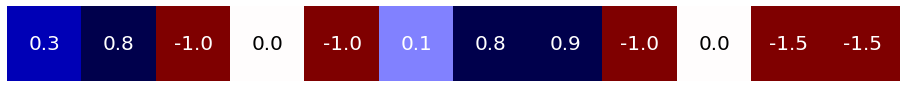

In [43]:
#...activate/uncomment the lines of interest

#lambdas=np.load("./data_produced/FitYourself_Lambdas.npy")
#lambdas=np.load("./data_produced/FitYourself_Lambdas_2OH2OH.npy")
#lambdas=np.load("./data_produced/FitYourself_Lambdas_NH2OH.npy")
#lambdas=np.load("./data_produced/FitYourself_Lambdas_NHO_05.npy")
#lambdas=np.load("./data_produced/FitYourself_Lambdas_*2OH.npy") 

#non-optimized 2OH2OH constraint parameters
#lambdas=np.load("./data_produced/parameters.npy")
#lambdas[0][11]=0.0

#non-optimized W-C (NHO_05) constraint parameters
#lambdas=np.load("./data_produced/parameters.npy")
#lambdas[0][4]=0.5*1.666666666666666

#non-optimized NH2OH constraint parameters
#lambdas=np.load("./data_produced/parameters.npy")
#lambdas[0][5]=0.0

#non-optimized *2OH constraint parameters
lambdas=np.load("./data_produced/parameters.npy")
lambdas[0][5]=0.0
lambdas[0][11]=0.0


gHBfix=[]
for i in range(12):
    gHBfix.append(0.0)

gHBfix[1]=1.0
gHBfix[6]=-0.5
gHBfix[8]=-0.5
gHBfix=np.array(gHBfix)   
lambdas=lambdas /1.666666666666666
lambdas=lambdas+gHBfix

cmap = plt.cm.get_cmap('gist_gray')
newlambdas =np.expand_dims(reorder(lambdas[0]), axis=0) 
newlambdas = np.where(abs(newlambdas) < 0.05, 0, newlambdas)
plt.matshow(newlambdas,cmap='seismic_r',vmin=-0.5,vmax=0.5)

counter=0
for (i, j), z in np.ndenumerate(newlambdas):
    c='white'
    if abs(z) < 0.05:
        c='black'
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=20, color=c)
    counter+=1
plt.axis('off')
plt.savefig('/net/sbp/srnas2/tfrahlki/PublicationFigures/ForcefieldRefinement/GHBFIX_nonopt_*2OH.svg') 
plt.show()

In [44]:
#compute the errors for each system depending on the parameters

#cost function for the training systems
def func_and_grad(par,noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,system):
    func=0.0
    funcGAGA=0.0
    funcUUCG=0.0
    chi2_native_GAGA=0.0
    chi2_native_UUCG=0.0
    chi2_noe=0.0
    chi2_unoe=0.0
    chi2_backbone1=0.0
    chi2_backbone2=0.0
    chi2_sugar=0.0
    
    GAGAnative=0.0
    UUCGnative=0.0
    
    USE_CUDA=True
    
    if system == 'GAGA':
        funcGAGA=0.0
        gradGAGA=np.zeros(len(par))
        if obs_weight[0] != 0:
            chi2_native_GAGA=0.0
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationGAGA,w, trajGAGA,cm_traj, USE_CUDA)
            GAGAnative=f[0]
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_GAGA+=diff**2
            funcGAGA=obs_weight[0]*TLweight*chi2_native_GAGA
            func+=prefactor*(funcGAGA+funcUUCG)
        
    if system == 'UUCG':
    
        funcUUCG=0.0
        gradUUCG=np.zeros(len(par))
        if obs_weight[1] != 0:
            chi2_native_UUCG=0.0
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationUUCG,w, trajUUCG,cm_traj, USE_CUDA)
            UUCGnative=f[0]
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population)
            if(diff<.0):
                    chi2_native_UUCG+=diff**2
            funcUUCG=obs_weight[1]*TLweight*chi2_native_UUCG

        func+=prefactor*(funcGAGA+funcUUCG)
    
    if system == 'GACC':
        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        if obs_weight[2] != 0:
            f=function(par,noe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_noe=np.sum(((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1])**2)/noe_exp.shape[0]
            func+=obs_weight[2]*noe_exp.shape[0]*chi2_noe

        if obs_weight[3] != 0:
            f=function(par,unoe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_unoe=0.0
            for i in range(len(f[0])):
                diff=f[0][i]**(-1/6)-unoe_exp[i,0]
                if(diff<.0):
                    chi2_unoe+=(diff/unoe_exp[i,1])**2/unoe_exp.shape[0]
            func+=obs_weight[3]*unoe_exp.shape[0]*chi2_unoe

        if obs_weight[4] != 0:
            f=function(par,backbone1,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone1=np.sum(((f[0]-backbone1_exp[:,0])/backbone1_exp[:,1])**2)/backbone1_exp.shape[0]
            func+=obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1

        if obs_weight[5] != 0:
            f=function(par,backbone2,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone2=np.sum(((f[0]-backbone2_exp[:,0])/backbone2_exp[:,1])**2)/backbone2_exp.shape[0]
            func+=obs_weight[5]*backbone2_exp.shape[0]*chi2_backbone2

        if obs_weight[6] != 0:
            f=function(par,sugar,w, trajGACC,cm_traj, USE_CUDA)
            chi2_sugar=np.sum(((f[0]-sugar_exp[:,0])/sugar_exp[:,1])**2)/sugar_exp.shape[0]
            func+=obs_weight[6]*sugar_exp.shape[0]*chi2_sugar

    func/=TLweight
    
    return float(func),float(GAGAnative),float(UUCGnative)


In [45]:
def main2():
    
    print("Load experimental data")
    noe_exp=np.loadtxt("./data_loaded/GACC/exp_noes",usecols=(2,3))
    unoe_exp=np.loadtxt("./data_loaded/GACC/exp_unobs-noes",usecols=(2,3))
    sugar_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-sugar",usecols=(1,2))
    backbone1_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-1",usecols=(1,2))
    backbone2_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-2",usecols=(1,2))
    print(noe_exp.shape)
    print(unoe_exp.shape)
    print(sugar_exp.shape)
    print(backbone1_exp.shape)
    print(backbone2_exp.shape)
    print('There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.')
    
    #get the names of the different simulations and there forcefield prefactors
    trajectoryNamesGACC=[]
    trajectoryNamesGAGA=[]
    trajectoryNamesUUCG=[]
    FFprefactorsGACC=[]
    FFprefactorsGAGA=[]
    FFprefactorsUUCG=[]

    with open("./data_loaded/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            l=line.split()
            file=l[0]+".skip.npy"
            trajectoryNamesGACC.append(file)
            FFprefactorsGACC.append(np.array(np.array(l)[1:],dtype='float'))

    with open("./data_loaded/coefficients_TLs.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                file=l[0]+".npy"
                if 'gaga' in line:
                    FFprefactorsGAGA.append(np.array(l[1:],dtype='float'))
                if 'uucg' in line:
                    FFprefactorsUUCG.append(np.array(l[1:],dtype='float'))

    firstFF='nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping/'
    secondFF='nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping/'
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+secondFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+secondFF+'gHBfix-parameters_state.rep0')

    #-------------------------------------------------------------------------------
    #load observables
    print('There are 14 simulations for GACC.')

    trajGACC=concatenate_simulation_data(['./data_loaded/GACC/' + x for x in trajectoryNamesGACC])
    backbone1=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-1",x) for x in trajectoryNamesGACC])
    backbone2=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-2",x) for x in trajectoryNamesGACC])
    sugar=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_sugar",x) for x in trajectoryNamesGACC])
    noe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","noe",x) for x in trajectoryNamesGACC])
    unoe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","unoe",x) for x in trajectoryNamesGACC])

    #apply forward models
    sugar=9.67*np.cos(sugar*np.pi/180)**2 - 2.03*np.cos(sugar*np.pi/180)
    backbone1=9.7*np.cos(backbone1*np.pi/180)**2 - 1.8*np.cos(backbone1*np.pi/180)
    backbone2=15.3*np.cos(backbone2*np.pi/180)**2 - 6.1*np.cos(backbone2*np.pi/180)+1.6
    noe=noe**-6
    unoe=unoe**-6
    print('There are 2 simulations per TL.')
    trajGAGA=read_TLs([x for x in trajectoryNamesGAGA])
    trajUUCG=read_TLs([x for x in trajectoryNamesUUCG])
    populationGAGA=trajGAGA[:,-1].reshape(-1,1)
    populationUUCG=trajUUCG[:,-1].reshape(-1,1)
    trajGAGA=trajGAGA[:,:12]
    trajUUCG=trajUUCG[:,:12]

    #to obtain the same parameters as published set prune=False
    prune=False
    if prune==True:
        skip=5000
        print("Pruning data, skip")
        trajGACC=trajGACC[::skip,:]
        backbone1=backbone1[::skip,:]
        backbone2=backbone2[::skip,:]
        sugar=sugar[::skip,:]
        noe=noe[::skip,:]
        unoe=unoe[::skip,:]
        populationGAGA=populationGAGA[::skip,:]
        populationUUCG=populationUUCG[::skip,:]
        trajGAGA=trajGAGA[::skip,:]
        trajUUCG=trajUUCG[::skip,:]
    else:
        skip=0

    print("Check shape of arrays:")
    print(trajGACC.shape)
    print(backbone1.shape)
    print(backbone2.shape)
    print(sugar.shape)
    print(noe.shape)
    print(unoe.shape)
    print(populationGAGA.shape)
    print(populationUUCG.shape)
    print(trajGAGA.shape)
    print(trajUUCG.shape)
    
    weightsGACC=np.exp(bussilab.wham.wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),threshold=1e-20,T=kBT).logW)
    weightsGAGA=np.exp(bussilab.wham.wham(calculate_TL_bias('GAGA','proposed',prune,skip,trajGAGA,FFprefactorsGAGA,trajUUCG,FFprefactorsUUCG),threshold=1e-20,T=kBT).logW)
    weightsUUCG=np.exp(bussilab.wham.wham(calculate_TL_bias('UUCG','proposed',prune,skip,trajGAGA,FFprefactorsGAGA,trajUUCG,FFprefactorsUUCG),threshold=1e-20,T=kBT).logW)

    eps=1e-30

    prefactor=1.0
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])
    
    obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
    
    regularization_list=['RelativeKishSize']

    alpha_star_list=[18.679135990207847] 

    error_list=[]
    
    chi2=[[],[],[]]
    chi2[0]=func_and_grad(np.zeros(12),noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,'GACC')[0]
    chi2[1]=func_and_grad(np.zeros(12),noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,'GAGA')[1]*100
    chi2[2]=func_and_grad(np.zeros(12),noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,'UUCG')[2]*100

    error_list.append(np.array(chi2))
    
    #...activate/uncomment the lines of interest
    
    #lambdas=np.load("./data_produced/FitYourself_Lambdas.npy")
    #lambdas=np.load("./data_produced/FitYourself_Lambdas_2OH2OH.npy")
    #lambdas=np.load("./data_produced/FitYourself_Lambdas_NH2OH.npy")
    #lambdas=np.load("./data_produced/FitYourself_Lambdas_NHO_05.npy")
    #lambdas=np.load("./data_produced/FitYourself_Lambdas_*2OH.npy")
    
    #non-optimized 2OH2OH constraint parameters
    #lambdas=np.load("./data_produced/parameters.npy")
    #lambdas[0][11]=0.0

    #non-optimized W-C constraint (NHO_05) parameters
    #lambdas=np.load("./data_produced/parameters.npy")
    #lambdas[0][4]=0.5*1.666666666666666

    #non-optimized NH2OH constraint parameters
    #lambdas=np.load("./data_produced/parameters.npy")
    #lambdas[0][5]=0.0

    #non-optimized *2OH constraint parameters
    lambdas=np.load("./data_produced/parameters.npy")
    lambdas[0][5]=0.0
    lambdas[0][11]=0.0


    chi2=[[],[],[]]
    chi2[0]=func_and_grad(lambdas,noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,'GACC')[0]
    chi2[1]=func_and_grad(lambdas,noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,'GAGA')[1]*100
    chi2[2]=func_and_grad(lambdas,noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,'UUCG')[2]*100

    error_list.append(np.array(chi2))
    
    #...activate/uncomment the lines of interest
    
    #np.save("./data_produced/chi2_FitYourself.npy", error_list)
    #np.save("./data_produced/chi2_FitYourself_2OH2OH.npy", error_list)
    #np.save("./data_produced/chi2_FitYourself_NH2OH.npy", error_list)
    #np.save("./data_produced/chi2_FitYourself_NHO_05.npy", error_list)
    #np.save("./data_produced/chi2_FitYourself_*2OH.npy", error_list)
    #np.save("./data_produced/chi2_FitYourself_nonopt_2OH2OH.npy", error_list)
    #np.save("./data_produced/chi2_FitYourself_nonopt_NHO_05.npy", error_list)
    #np.save("./data_produced/chi2_FitYourself_nonopt_NH2OH.npy", error_list)
    np.save("./data_produced/chi2_FitYourself_nonopt_*2OH.npy", error_list)

In [46]:
executor2=concurrent.futures.ProcessPoolExecutor(max_workers=1)
future2 = executor2.submit(main2)

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)


In [48]:
print(future2)

<Future at 0x7f7222fc4430 state=finished returned NoneType>


In [49]:
#cost function for the validation systems
def cost_func(par,system,backbone1_exp_list,backbone2_exp_list,sugar_exp_list,noe_exp_list,unoe_exp_list,backbone1_list,backbone2_list,sugar_list,noe_list,unoe_list,traj_list,weights_list,TLweight,population_list):
    
    obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0]
    eps=1e-30
    prefactor=1.0
    
    if system == 'CAAU':
            s=0
    if system == 'UUUU':
            s=1
    if system == 'UUCG':
            s=2       
    
    func=0.0
    total_number_observables=0
    if system in ['CAAU', 'UUUU']:
        
        total_number_observables+=obs_weight[0]*backbone1_exp_list[s].shape[0]
        total_number_observables+=obs_weight[1]*backbone2_exp_list[s].shape[0]
        total_number_observables+=obs_weight[2]*sugar_exp_list[s].shape[0]
        total_number_observables+=obs_weight[3]*noe_exp_list[s].shape[0]
        total_number_observables+=obs_weight[4]*unoe_exp_list[s].shape[0]
            
    else:
        total_number_observables+=TLweight
     
    if system in ['CAAU', 'UUUU']: 
        
        UUCGnative=0
            
        weights=weights_list[s]
        traj=traj_list[s]
        
        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(traj,weights, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()   
            
        #---------------------------------------------------------------------------------------
        
        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(traj,weights, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)
        
        
        #for the first 3 sequences there are NOE data
        backbone1=backbone1_list[s]
        backbone2=backbone2_list[s]
        sugar=sugar_list[s]

        backbone1_exp=backbone1_exp_list[s]
        backbone2_exp=backbone2_exp_list[s]
        sugar_exp=sugar_exp_list[s]

        f=function(par,backbone1,w, traj,cm_traj, USE_CUDA)
        chi2_backbone1=np.sum(((f[0]-backbone1_exp[:,0])/backbone1_exp[:,1])**2)/backbone1_exp.shape[0]
        func+=obs_weight[0]*backbone1_exp.shape[0]*chi2_backbone1

        f=function(par,backbone2,w, traj,cm_traj, USE_CUDA)
        chi2_backbone2=np.sum(((f[0]-backbone2_exp[:,0])/backbone2_exp[:,1])**2)/backbone2_exp.shape[0]
        func+=obs_weight[1]*backbone2_exp.shape[0]*chi2_backbone2

        f=function(par,sugar,w, traj,cm_traj, USE_CUDA)
        chi2_sugar=np.sum(((f[0]-sugar_exp[:,0])/sugar_exp[:,1])**2)/sugar_exp.shape[0]
        func+=obs_weight[2]*sugar_exp.shape[0]*chi2_sugar

        noe=noe_list[s]
        noe_exp=noe_exp_list[s]
        f=function(par,noe,w, traj,cm_traj, USE_CUDA)
        chi2_noe=np.sum(((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1])**2)/noe_exp.shape[0]
        func+=obs_weight[3]*noe_exp.shape[0]*chi2_noe

        unoe=unoe_list[s]
        unoe_exp=unoe_exp_list[s]
        f=function(par,unoe,w, traj,cm_traj, USE_CUDA)
        chi2_unoe=0.0
        grad_unoe=np.zeros(len(par))
        for i in range(len(f[0])):
            diff=f[0][i]**(-1/6)-unoe_exp[i,0]
            if(diff<.0):
                chi2_unoe+=(diff/unoe_exp[i,1])**2/unoe_exp.shape[0]
        func+=obs_weight[4]*unoe_exp.shape[0]*chi2_unoe
                
    else:
        weights=weights_list[s]
        traj=traj_list[s]
        
        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(traj,weights, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()   

        population=np.array(population_list[0])

        chi2_native_pop=0.0
        grad_native_pop=np.zeros(len(par))
        f=function(par,population,w, traj,cm_traj, USE_CUDA)
        UUCGnative=f[0]
        target_population=0.5
        diff=np.log(f[0]+eps)-np.log(target_population) #i want to penalize diff < 0, because large and negative means non-native
        if(diff<.0):
                chi2_native_pop+=diff**2
        func+=obs_weight[5]*TLweight*chi2_native_pop

        
    func/=total_number_observables
    
    return float(func),float(UUCGnative)

def read_exp(path, columns):
    matrix=[]
    for col in range(columns):
        matrix.append([])
    with open(path, 'r') as f:
        for line in f:
            if '#' not in line:
                nums=line.split()
                for col in range(columns):
                    matrix[col].append(nums[col])
    return np.array(matrix)

def read_UNCG(files):
    corr=[]
    for file in files:
        with open(file, "r") as f:
            for line in f:
                if(line[0]=='#'):
                    continue
                else:
                    nums=line.split()
                    if nums:
                        corr.append(np.array([float(i) for i in nums]))
    return np.array(corr)

In [50]:
def main3():
    
    print("Load experimental data")
    noe_exp=np.loadtxt("./data_loaded/GACC/exp_noes",usecols=(2,3))
    unoe_exp=np.loadtxt("./data_loaded/GACC/exp_unobs-noes",usecols=(2,3))
    sugar_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-sugar",usecols=(1,2))
    backbone1_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-1",usecols=(1,2))
    backbone2_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-2",usecols=(1,2))
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])
    
    
    #load validation set data
    Validation_sequence_list=['CAAU','UUUU','UUCG']

    backbone1_exp_list=[]
    backbone2_exp_list=[]
    sugar_exp_list=[]
    noe_exp_list=[]
    unoe_exp_list=[]

    FFprefactorsCAAU=[]
    FFprefactorsUUUU=[]
    FFprefactorsGAGA=[]
    #CAAU parameters
    vojtech_dir='/net/sbp/srnas2/vmlynsky/CAAU-for-REWEIGHTING/gHBfix-optimal' 
    with open("./data_loaded/CAAU/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                FFprefactorsCAAU.append(np.array(l[1:],dtype='float'))
    #UUUU parameters
    with open("./data_loaded/UUUU/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                FFprefactorsUUUU.append(np.array(l[1:],dtype='float'))
    
    with open("./data_loaded/coefficients_TLs.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                file=l[0]+".npy"
                if 'gaga' in line:
                    FFprefactorsGAGA.append(np.array(l[1:],dtype='float'))


    backbone1_list=[]
    backbone2_list=[]
    sugar_list=[]
    noe_list=[]
    unoe_list=[]
    population_list=[]
    traj_list=[]
    weights_list=[]

    for s,Sequence in enumerate(Validation_sequence_list):
        print(Sequence)  

        if Sequence == 'UUCG':
            print('There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.')

            trajectoryNamesUNCG=[]
            FFprefactorsUNCG=[]
            with open("./data_loaded/UUCG_validation/coefficients_gHBfix21.dat","r") as fp:
                for line in fp:
                    if(line[0]=='#'):
                        continue
                    if line.strip():
                        l=line.split()
                        FFprefactorsUNCG.append(np.array(l[1:],dtype='float'))
                        file='uucg_ghbfix21_rep0_HBfix-energy_state.dat' 
                        trajectoryNamesUNCG.append('./data_loaded/UUCG_validation/'+file)

            print('Additionally there is the UUCG validation simulation with gHBfix21')
            trajUNCG=read_UNCG([x for x in trajectoryNamesUNCG])
            populationUNCG=trajUNCG[:,-1].reshape(-1,1)
            trajUNCG=trajUNCG[:,:12]

            populationUNCG=populationUNCG[1:]
            trajUNCG=trajUNCG[1:]

            print(trajUNCG.shape)
            print(populationUNCG.shape)

            traj_list.append(trajUNCG)
            population_list.append(populationUNCG)
            
            Metadweight=[]
            with open("./data_loaded/UUCG_validation/weights.rep0","r") as fp:
                for line in fp:
                    Metadweight.append(float(line))
            MetadPot=kBT*np.log(Metadweight)

        if Sequence == 'CAAU' or Sequence == 'UUUU':
            j3_data=read_exp('./data_loaded/%s/j3_%s.exp.dat' %(Sequence,Sequence),3 )
            if Sequence=='CAAU':
                unoe_data=read_exp('./data_loaded/%s/formatted_unoe_%s.exp.dat' %(Sequence,Sequence),4 )
            else:
                unoe_data=read_exp('./data_loaded/%s/unoe_%s.exp.dat' %(Sequence,Sequence),4 )
            noe_data=read_exp('./data_loaded/%s/noe_%s.exp.dat' %(Sequence,Sequence),5 )


            print(j3_data.shape)
            print(noe_data.shape)
            print(unoe_data.shape)
            #split j3 into backbone and sugar

            backbone1_exp=[]
            backbone2_exp=[]
            sugar_exp=[]
            for e,elem in enumerate(j3_data.T):
                #print(elem[0])
                if '1H5H4' in elem[0] or '2H5H4'in elem[0]:
                    backbone1_exp.append([float(elem[1]),float(elem[2])])
                if '1H5P' in elem[0] or '2H5P' in elem[0] or 'H3P' in elem[0]:
                    backbone2_exp.append([float(elem[1]),float(elem[2])])
                if 'H1H2'  in elem[0] or 'H2H3' in elem[0] or 'H3H4' in elem[0]:
                    sugar_exp.append([float(elem[1]),float(elem[2])])

            backbone1_exp=np.array(backbone1_exp)
            if Sequence=='CAAU':
                backbone2_exp=np.array(backbone2_exp[:-1])
            backbone2_exp=np.array(backbone2_exp)
            sugar_exp=np.array(sugar_exp)
            print('backbone1: ',backbone1_exp.shape)
            print('backbone2: ',backbone2_exp.shape)
            print('sugar: ',sugar_exp.shape)

            noe_exp=noe_data.T[:,2:]
            unoe_exp=unoe_data.T[:,2:]
            noe_exp=noe_exp[:,:].astype(float)
            noe_exp=np.vstack((noe_exp[:,1],noe_exp[:,2]-noe_exp[:,0])).T
            unoe_exp=unoe_exp[:,:].astype(float)
            print('NOE: ',noe_exp.shape)
            print('uNOE: ',unoe_exp.shape)

            backbone1_exp_list.append(backbone1_exp)
            backbone2_exp_list.append(backbone2_exp)
            sugar_exp_list.append(sugar_exp)
            noe_exp_list.append(noe_exp)
            unoe_exp_list.append(unoe_exp)

            backbone1=np.load('./data_loaded/%s/backbone1.npy' %(Sequence))
            backbone2=np.load('./data_loaded/%s/backbone2.npy' %(Sequence))
            sugar=np.load('./data_loaded/%s/sugar.npy' %(Sequence))
            noe=np.load('./data_loaded/%s/NOE.npy' %(Sequence))
            unoe=np.load('./data_loaded/%s/uNOE.npy' %(Sequence))

            backbone1=9.7*np.cos(backbone1*np.pi/180)**2 - 1.8*np.cos(backbone1*np.pi/180)
            backbone2=15.3*np.cos(backbone2*np.pi/180)**2 - 6.1*np.cos(backbone2*np.pi/180)+1.6
            sugar=9.67*np.cos(sugar*np.pi/180)**2 - 2.03*np.cos(sugar*np.pi/180)
            noe=noe**-6
            unoe=unoe**-6

            if Sequence == 'CAAU':
                traj=np.load('./data_loaded/%s/traj.npy' %(Sequence))
            if Sequence == 'UUUU':
                traj=np.load('./data_loaded/%s/traj.npy' %(Sequence))
                traj=np.insert(traj, 1, np.zeros(traj.shape[0]), axis=1)
                traj=np.insert(traj, 7, np.zeros(traj.shape[0]), axis=1)

            print('backbone1: ',backbone1.shape)
            print('backbone2: ',backbone2.shape)
            print('sugar: ',sugar.shape)
            print('NOE: ',noe.shape)
            print('uNOE: ',unoe.shape)
            print('corrections: ', traj.shape)


            backbone1_list.append(backbone1)
            backbone2_list.append(backbone2)
            sugar_list.append(sugar)
            noe_list.append(noe)
            unoe_list.append(unoe)
            traj_list.append(traj)

        if Sequence == 'CAAU':
            weights=np.exp(bussilab.wham.wham(np.matmul(traj_list[s],np.transpose(FFprefactorsCAAU-FFprefactorsGAGA[1])),threshold=1e-20,T=kBT).logW)
        if Sequence == 'UUUU':
            weights=np.exp(bussilab.wham.wham(np.matmul(traj_list[s],np.transpose(FFprefactorsUUUU-FFprefactorsGAGA[1])),threshold=1e-20,T=kBT).logW)
        if Sequence=='UUCG':
            weights=np.exp(bussilab.wham.wham(np.matmul(traj_list[s],np.transpose(FFprefactorsUNCG-FFprefactorsGAGA[1]))+MetadPot.reshape(-1,1),threshold=1e-20,T=kBT).logW)
    
        print('weights: ',weights.shape)
        weights_list.append(weights)

    
    CAAU_ref_error=cost_func(np.zeros(12),'CAAU',backbone1_exp_list,backbone2_exp_list,sugar_exp_list,noe_exp_list,unoe_exp_list,backbone1_list,backbone2_list,sugar_list,noe_list,unoe_list,traj_list,weights_list,TLweight,population_list)[0]
    UUUU_ref_error=cost_func(np.zeros(12),'UUUU',backbone1_exp_list,backbone2_exp_list,sugar_exp_list,noe_exp_list,unoe_exp_list,backbone1_list,backbone2_list,sugar_list,noe_list,unoe_list,traj_list,weights_list,TLweight,population_list)[0]
    UUCG_native_ref_population=cost_func(np.zeros(12),'UUCG',backbone1_exp_list,backbone2_exp_list,sugar_exp_list,noe_exp_list,unoe_exp_list,backbone1_list,backbone2_list,sugar_list,noe_list,unoe_list,traj_list,weights_list,TLweight,population_list)[1]*100
    
    #...activate/uncomment the lines of interest
    
    #lambdas=np.load("./data_produced/FitYourself_Lambdas.npy")
    #lambdas=np.load("./data_produced/FitYourself_Lambdas_2OH2OH.npy") 
    #lambdas=np.load("./data_produced/FitYourself_Lambdas_NH2OH.npy")
    #lambdas=np.load("./data_produced/FitYourself_Lambdas_NHO_05.npy")
    #lambdas=np.load("./data_produced/FitYourself_Lambdas_*2OH.npy")
    
    #non-optimized 2OH2OH constraint parameters
    #lambdas=np.load("./data_produced/parameters.npy")
    #lambdas[0][11]=0.0

    #non-optimized W-C constraint (NHO_05) parameters
    #lambdas=np.load("./data_produced/parameters.npy")
    #lambdas[0][4]=0.5*1.666666666666666

    #non-optimized NH2OH constraint parameters
    #lambdas=np.load("./data_produced/parameters.npy")
    #lambdas[0][5]=0.0

    #non-optimized *2OH constraint parameters
    lambdas=np.load("./data_produced/parameters.npy")
    lambdas[0][5]=0.0
    lambdas[0][11]=0.0
    
    CAAU_error=cost_func(lambdas,'CAAU',backbone1_exp_list,backbone2_exp_list,sugar_exp_list,noe_exp_list,unoe_exp_list,backbone1_list,backbone2_list,sugar_list,noe_list,unoe_list,traj_list,weights_list,TLweight,population_list)[0]
    UUUU_error=cost_func(lambdas,'UUUU',backbone1_exp_list,backbone2_exp_list,sugar_exp_list,noe_exp_list,unoe_exp_list,backbone1_list,backbone2_list,sugar_list,noe_list,unoe_list,traj_list,weights_list,TLweight,population_list)[0]
    UUCG_native_population=cost_func(lambdas,'UUCG',backbone1_exp_list,backbone2_exp_list,sugar_exp_list,noe_exp_list,unoe_exp_list,backbone1_list,backbone2_list,sugar_list,noe_list,unoe_list,traj_list,weights_list,TLweight,population_list)[1]*100
    
    #error_list=np.load("./data_produced/chi2_FitYourself.npy")
    #error_list=np.load("./data_produced/chi2_FitYourself_2OH2OH.npy")
    #error_list=np.load("./data_produced/chi2_FitYourself_NH2OH.npy")
    #error_list=np.load("./data_produced/chi2_FitYourself_NHO_05.npy")
    #error_list=np.load("./data_produced/chi2_FitYourself_*2OH.npy")
    #error_list=np.load("./data_produced/chi2_FitYourself_nonopt_2OH2OH.npy")
    #error_list=np.load("./data_produced/chi2_FitYourself_nonopt_NHO_05.npy")
    #error_list=np.load("./data_produced/chi2_FitYourself_nonopt_NH2OH.npy")
    error_list=np.load("./data_produced/chi2_FitYourself_nonopt_*2OH.npy")
    
    error_list=np.vstack((error_list,[CAAU_ref_error,UUUU_ref_error,UUCG_native_ref_population]))
    error_list=np.vstack((error_list,[CAAU_error,UUUU_error,UUCG_native_population]))
    #np.save("./data_produced/chi2_FitYourself.npy",error_list)
    #np.save("./data_produced/chi2_FitYourself_2OH2OH.npy",error_list)
    #np.save("./data_produced/chi2_FitYourself_NH2OH.npy",error_list)
    #np.save("./data_produced/chi2_FitYourself_NHO_05.npy",error_list)
    #np.save("./data_produced/chi2_FitYourself_*2OH.npy",error_list)
    #np.save("./data_produced/chi2_FitYourself_nonopt_2OH2OH.npy", error_list)
    #np.save("./data_produced/chi2_FitYourself_nonopt_NHO_05.npy", error_list)
    #np.save("./data_produced/chi2_FitYourself_nonopt_NH2OH.npy", error_list)
    np.save("./data_produced/chi2_FitYourself_nonopt_*2OH.npy", error_list)

In [51]:
executor3=concurrent.futures.ProcessPoolExecutor(max_workers=1)
future3 = executor3.submit(main3)

Load experimental data
CAAU
(3, 28)
(5, 39)
(4, 377)
backbone1:  (8, 2)
backbone2:  (8, 2)
sugar:  (11, 2)
NOE:  (39, 2)
uNOE:  (377, 2)
backbone1:  (1000000, 8)
backbone2:  (1000000, 8)
sugar:  (1000000, 11)
NOE:  (1000000, 39)
uNOE:  (1000000, 377)
corrections:  (1000000, 12)
weights:  (1000000,)
UUUU
(3, 25)
(5, 9)
(4, 283)
backbone1:  (6, 2)
backbone2:  (9, 2)
sugar:  (10, 2)
NOE:  (9, 2)
uNOE:  (283, 2)
backbone1:  (1000000, 6)
backbone2:  (1000000, 9)
sugar:  (1000000, 10)
NOE:  (1000000, 9)
uNOE:  (1000000, 283)
corrections:  (1000000, 12)
weights:  (1000000,)
UUCG
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
Additionally there is the UUCG validation simulation with gHBfix21
(500000, 12)
(500000, 1)
weights:  (500000,)


In [53]:
print(future3)

<Future at 0x7f7220ec7940 state=finished returned NoneType>


In [54]:
#...activate/uncomment the lines of interest

#error_list=np.load("./data_produced/chi2_FitYourself.npy")
#error_list=np.load("./data_produced/chi2_FitYourself_2OH2OH.npy")
#error_list=np.load("./data_produced/chi2_FitYourself_NH2OH.npy")
#error_list=np.load("./data_produced/chi2_FitYourself_NHO_05.npy")
#error_list=np.load("./data_produced/chi2_FitYourself_*2OH.npy")
#error_list=np.load("./data_produced/chi2_FitYourself_nonopt_2OH2OH.npy")
#error_list=np.load("./data_produced/chi2_FitYourself_nonopt_NHO_05.npy")
#error_list=np.load("./data_produced/chi2_FitYourself_nonopt_NH2OH.npy")
error_list=np.load("./data_produced/chi2_FitYourself_nonopt_*2OH.npy")

def trunc(values, decs):
    return np.trunc(values*10**decs)/(10**decs)

output=[]

for iteration in error_list:
    temp=[]
    for e,elem in enumerate(iteration):
        temp.append(trunc(elem, decs=3))
    output.append(temp)

print('training data set')
print('reference vs fitting')
print('GAGA native population: ',output[0][1],output[1][1])
print('UUCG native population: ',output[0][2],output[1][2])
print('GACC error: ',output[0][0],output[1][0])

print('validation data set')
print('reference vs fitting')
print('CAAU error: ',output[2][0],output[3][0])
print('UUUU error: ',output[2][1],output[3][1])
print('UUCG native population: ',output[2][2],output[3][2])

training data set
reference vs fitting
GAGA native population:  23.679 61.679
UUCG native population:  0.016 13.68
GACC error:  0.242 0.677
validation data set
reference vs fitting
CAAU error:  5.0 3.893
UUUU error:  1.73 1.447
UUCG native population:  0.002 11.133
